# The binomial distribution

In probability theory and statistics, the binomial distribution with parameters $n$ and $p$ is the **discrete probability distribution of the number of successes in a sequence of n independent experiments, each asking a yes–no question**, and each with its own Boolean-valued outcome: success (with probability p) or failure (with probability q = 1 − p). A single success/failure experiment is also called a Bernoulli trial or Bernoulli experiment, and a sequence of outcomes is called a Bernoulli process; for a single trial, i.e., n = 1, the binomial distribution is a Bernoulli distribution. The binomial distribution is the basis for the popular binomial test of statistical significance (from [Wikipedia](https://en.wikipedia.org/wiki/Binomial_distribution)).

2 main parameters:
- The parameter that determines the number of trials per experiments ${\displaystyle n\in \{0,1,2,\ldots \}}$ 
- The success probability for each trial ${\displaystyle p\in [0,1]}{\displaystyle p\in [0,1]}$

In [1]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(10, 6)})

## Simulating data

**I toss a coin 10 times, what is the probability of observing k "heads"?**

Scipy reference:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html

In [2]:
# 100 coin tosses
stats.binom.rvs(p=.5, n=1, size=100) # same as np.random.binomial(p=.5, n=1, size=100)

array([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0])

In [3]:
# 100 experiments of 10 coin tosses
stats.binom.rvs(p=.5, n=10, size=100)

array([4, 8, 7, 5, 6, 3, 8, 7, 5, 2, 6, 5, 3, 4, 6, 5, 3, 3, 2, 6, 6, 3,
       5, 7, 4, 7, 7, 4, 5, 5, 3, 6, 6, 5, 6, 5, 5, 6, 7, 6, 5, 4, 6, 5,
       4, 6, 3, 5, 8, 5, 5, 6, 5, 3, 5, 6, 4, 4, 5, 3, 7, 4, 5, 4, 4, 5,
       5, 3, 6, 5, 6, 6, 6, 5, 7, 5, 3, 6, 5, 3, 6, 4, 8, 3, 7, 6, 6, 3,
       4, 3, 4, 5, 6, 2, 3, 5, 5, 4, 9, 4])

## Plotting the PMF

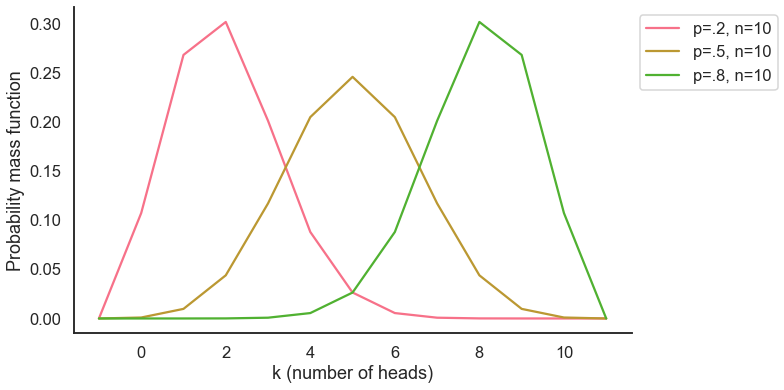

In [4]:
k = np.arange(-1, 12, 1)

plt.plot(k, stats.binom.pmf(k, p=.2, n=10), label='p=.2, n=10')
plt.plot(k, stats.binom.pmf(k, p=.5, n=10), label='p=.5, n=10')
plt.plot(k, stats.binom.pmf(k, p=.8, n=10), label='p=.8, n=10')

plt.xlabel('k (number of heads)')
plt.ylabel('Probability mass function')
plt.legend(bbox_to_anchor=(1,1))
sns.despine();

## Estimating $p$

When we collect the data from an experiment, we do not know what the underlying $p$ is, so we need to estimate it.

The parameter $p$ is constrained between 0 and 1 and follows a **[beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)**, with parameters $\alpha > 0$ shape (real) and 
$\beta > 0$ shape (real):

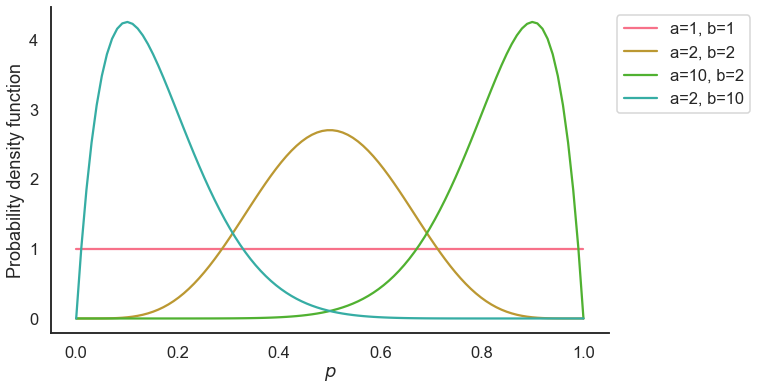

In [5]:
p = np.linspace(0, 1, 100)

plt.plot(p, stats.beta.pdf(p, a=1, b=1), label='a=1, b=1') # no evidence
plt.plot(p, stats.beta.pdf(p, a=6, b=6), label='a=2, b=2') # 5 successes on 10
plt.plot(p, stats.beta.pdf(p, a=10, b=2), label='a=10, b=2') # 9 success on 10
plt.plot(p, stats.beta.pdf(p, a=2, b=10), label='a=2, b=10') # 1 success on 10

plt.xlabel('$p$')
plt.ylabel('Probability density function')
plt.legend(bbox_to_anchor=(1,1))
sns.despine();

In [6]:
# Generate some data
generating_p = .45
generating_n = 10
sample_size = 1
data = stats.binom.rvs(p=generating_p, n=generating_n, size=sample_size)
data

array([5])

In [7]:
# writing the first stan model

model_code = """

data {
    int<lower=1> N;             // how many coin tosses?
    int<lower=1> K;             // how many successes?
    }
    
parameters {
    real<lower=0, upper=1> p;   // free parameter
    }
    
model {
    p ~ beta(1, 1);             // prior belief
    K ~ binomial(N, p);         // how are the data distributed?
    }
"""

In [8]:
# define input for the model
data_dict = {'N': generating_n,
             'K': data[0]}

In [9]:
# set sampling parameters
n_iter = 2000
n_warmup = 1000
n_chains = 2

In [10]:
import pystan

In [11]:
# fit the model
fit = pystan.stan(model_code=model_code, 
                  data=data_dict,
                  iter=n_iter, 
                  warmup=n_warmup,
                  chains=n_chains)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ad79495fdc7b26aab5fe485ed33db00 NOW.


In [12]:
# Extract the results
samples = fit.to_dataframe(pars=None, permuted=False, diagnostics=False)

We can vizualize the posterior samples as pandas DataFrame with `(n_iter-n_warmup)*n_chains` rows, and the posterior sample of our free parameter $p$ as column.

(Note: `lp__` is not important for now, but see https://www.jax.org/news-and-insights/jax-blog/2015/october/lp-in-stan-output)

In [13]:
samples.set_index(['chain', 'draw']).drop(columns = "warmup")

p      lp__
chain draw                    
0     0     0.405687 -8.535135
      1     0.448073 -8.382832
      2     0.540196 -8.356670
      3     0.459815 -8.356648
      4     0.522864 -8.330325
...              ...       ...
1     995   0.663189 -8.993567
      996   0.664666 -9.006593
      997   0.363341 -8.783607
      998   0.350499 -8.879689
      999   0.361349 -8.797850

[2000 rows x 2 columns]

## Visualize the results

### With seaborn/matplotlib

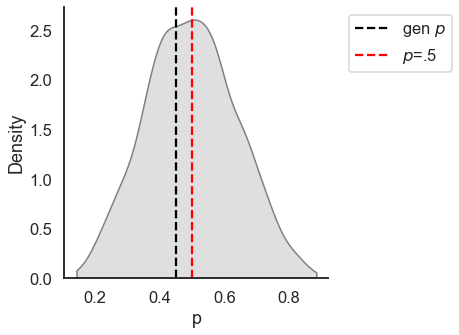

In [14]:
sns.displot(samples['p'], kind='kde', fill=True, cut=0, color='grey')
plt.axvline(generating_p, color='k', linestyle='--', label="gen $p$");
plt.axvline(.5, color='red', linestyle='--', label='$p$=.5')

plt.legend(bbox_to_anchor=(1.5, 1));

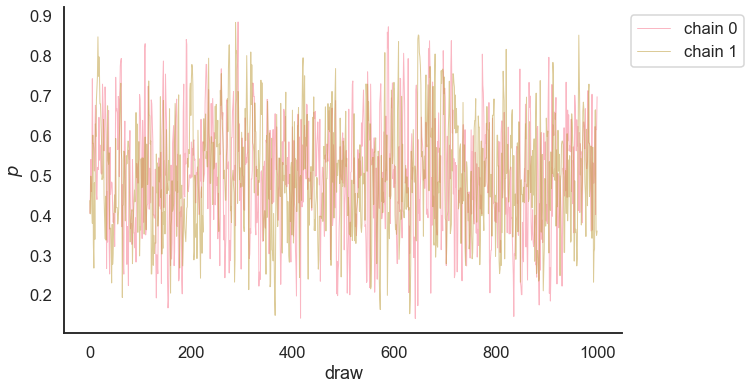

In [15]:
plt.plot(samples.set_index(['chain', 'draw']).loc[0, 'p'], label='chain 0', alpha=.5, lw=1)
plt.plot(samples.set_index(['chain', 'draw']).loc[1, 'p'], label='chain 1', alpha=.5, lw=1)

plt.ylabel('$p$')
plt.xlabel('draw')
plt.legend(bbox_to_anchor=(1,1))
sns.despine();

### With arviz

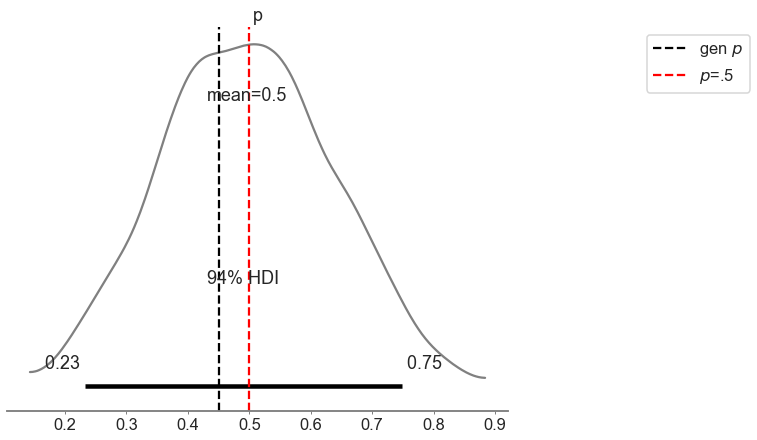

In [16]:
import arviz as az

az.plot_posterior(fit, color='grey')
plt.axvline(generating_p, color='k', linestyle='--', label="gen $p$");
plt.axvline(.5, color='red', linestyle='--', label='$p$=.5')

plt.legend(bbox_to_anchor=(1.5, 1));

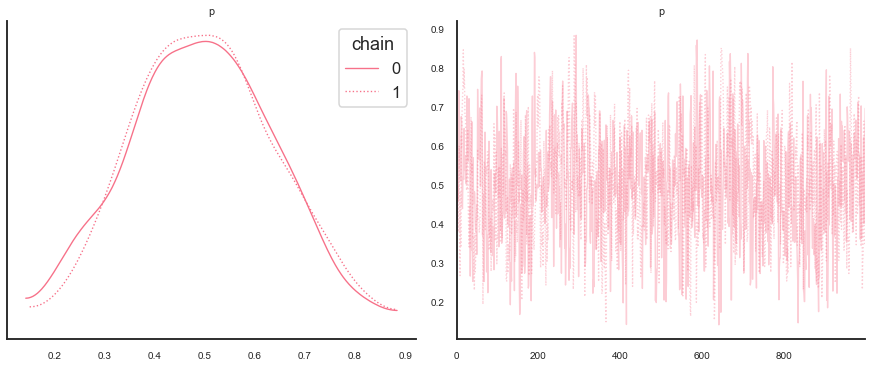

In [17]:
az.plot_trace(fit, figsize=(12, 5), legend=True)

sns.despine();

**ON YOUR OWN**: Try out different `generating_n` and `generating_p`, or to run the same model (with the same parameters) with different data a few times. What do you observe?

## Comparing two binomial rates $p$

In [18]:
# Generate some data
generating_p1 = .45
generating_p2 = .65
generating_n = 30
sample_size = 1
data1 = stats.binom.rvs(p=generating_p1, n=generating_n, size=sample_size)
data2 = stats.binom.rvs(p=generating_p2, n=generating_n, size=sample_size)

In [19]:
# writing the first stan model

model_code = """

data {
    int<lower=1> N1;             // how many coin tosses?
    int<lower=1> N2;             // how many coin tosses?
    int<lower=1> K1;             // how many successes?
    int<lower=1> K2;             // how many successes?
    }
    
parameters {
    real<lower=0, upper=1> p_1;   // free parameter
    real<lower=0, upper=1> p_2;   // free parameter
    }

transformed parameters {
    real<lower=-1, upper=1> p_difference;
    real<lower=0, upper=1> p_mean;
    
    p_difference = p_1 - p_2;
    p_mean = (p_1 + p_2)/2;
    
    }
    
model {
    p_1 ~ beta(1, 1);               // prior belief
    p_2 ~ beta(1, 1);               // prior belief
    K1 ~ binomial(N1, p_1);         // how are the data distributed?
    K2 ~ binomial(N2, p_2);         // how are the data distributed?
    }
"""

In [20]:
# define input for the model
data_dict = {'N1': generating_n,
             'N2': generating_n,
             'K1': data1[0],
             'K2': data2[0]}

In [21]:
# set sampling parameters
n_iter = 3000
n_warmup = 1000
n_chains = 2

In [22]:
# fit the model
fit = pystan.stan(model_code=model_code, 
                  data=data_dict,
                  iter=n_iter, 
                  warmup=n_warmup,
                  chains=n_chains)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c6ccd893477578a10ef0439adacc8929 NOW.


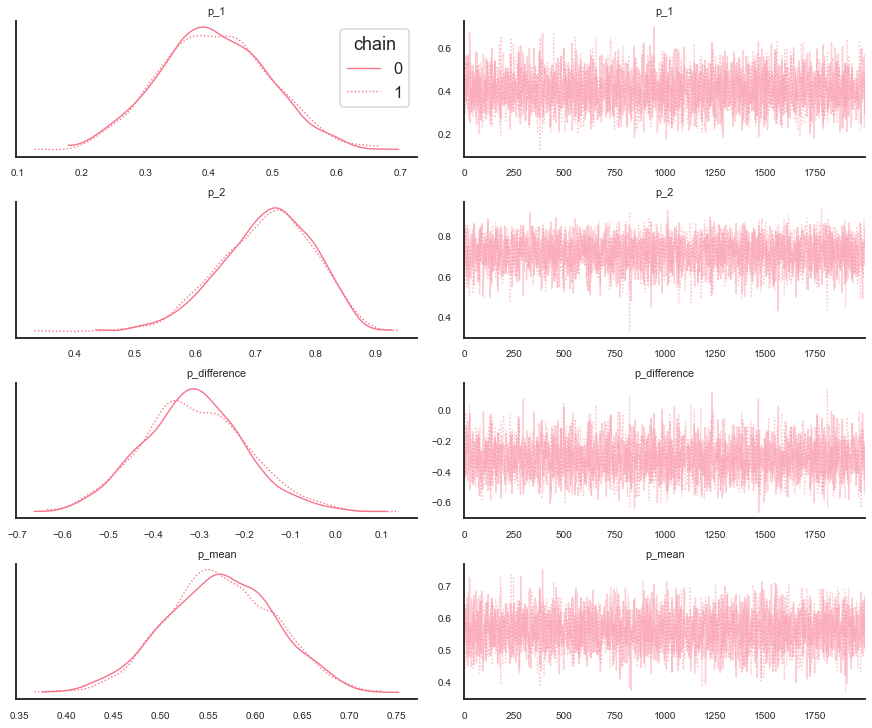

In [23]:
az.plot_trace(fit, figsize=(12, 10), legend=True)

sns.despine();

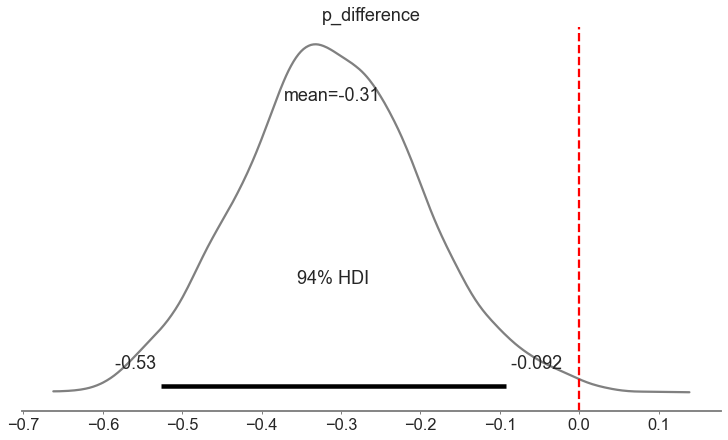

In [24]:
az.plot_posterior(fit, var_names=["p_difference"], color='grey')
plt.axvline(0, color='red', linestyle='--');

**ON YOUR OWN**: Try out different `generating_p1` and `generating_p2`. What do you observe?

## Posterior predictives and log likelihood

See stan manual: https://mc-stan.org/docs/2_21/functions-reference/binomial-distribution.html

In [25]:
generating_p = .4
generating_n = 10
sample_size = 100
data = stats.binom.rvs(p=generating_p, n=generating_n, size=sample_size)
data

array([1, 4, 4, 3, 3, 3, 3, 5, 6, 4, 3, 4, 2, 2, 3, 4, 6, 6, 4, 4, 3, 5,
       3, 2, 5, 4, 6, 2, 4, 5, 7, 5, 3, 3, 2, 4, 3, 3, 3, 2, 6, 4, 3, 5,
       5, 3, 4, 5, 1, 2, 6, 3, 3, 4, 7, 3, 4, 4, 6, 4, 2, 3, 4, 5, 6, 4,
       4, 4, 4, 3, 3, 5, 3, 6, 5, 6, 3, 4, 6, 2, 2, 3, 6, 3, 4, 2, 3, 5,
       6, 5, 0, 3, 2, 3, 6, 5, 5, 4, 6, 3])

In [26]:
model_code = """

data {
    int<lower=1> N;             // how many coin tosses per experiment?
    int<lower=1> M;             // how many experiments?
    int<lower=0> y[M];          // how many successes in each experiment?
    }
    
parameters {
    real<lower=0, upper=1> p;   // free parameter
    }
    
model {
    p ~ beta(1, 1);             // prior belief
    y ~ binomial(N, p);         // how are the data distributed?
    }
    
generated quantities {
    vector[M] log_likelihood;
    vector[M] y_hat;
    
    {for (i in 1:M) {
        log_likelihood[i] = binomial_lpmf(y[i] | N, p);      // log likelihood of each data point y[i] 
        y_hat[i] = binomial_rng(N, p);                       // generated data for each sample p
    }
    }
}
"""

In [27]:
data_dict = {'N': generating_n,
             'M': sample_size,
             'y': data}

In [28]:
# set sampling parameters
n_iter = 3000
n_warmup = 1000
n_chains = 2

In [29]:
# fit the model
fit = pystan.stan(model_code=model_code, 
                  data=data_dict,
                  iter=n_iter, 
                  warmup=n_warmup,
                  chains=n_chains)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7ee23f57bba0362a0598cdc56eb1c9bb NOW.


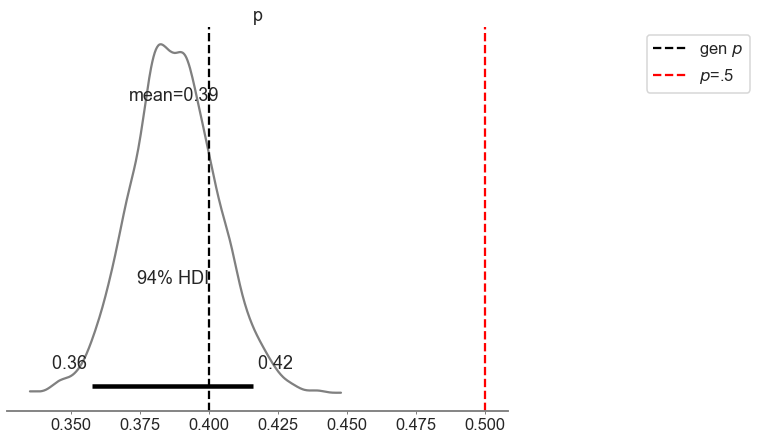

In [30]:
az.plot_posterior(fit, var_names=["p"], color='grey')
plt.axvline(generating_p, color='k', linestyle='--', label="gen $p$");
plt.axvline(.5, color='red', linestyle='--', label='$p$=.5')

plt.legend(bbox_to_anchor=(1.5, 1));

In [31]:
# Extract the results in pandas
samples = fit.to_dataframe(pars=['y_hat'], permuted=True, diagnostics=False)
samples

,chain,draw,warmup,permutation,chain_permutation,permutation_order,chain_permutation_order,y_hat[100],y_hat[10],y_hat[11],...,y_hat[91],y_hat[92],y_hat[93],y_hat[94],y_hat[95],y_hat[96],y_hat[97],y_hat[98],y_hat[99],y_hat[9]
243,0,243,0,667,667,0,0,5.0,4.0,5.0,...,4.0,4.0,5.0,3.0,6.0,3.0,3.0,4.0,4.0,5.0
1298,0,1298,0,845,845,1,1,6.0,5.0,7.0,...,5.0,2.0,5.0,5.0,3.0,0.0,4.0,3.0,1.0,4.0
330,0,330,0,1578,1578,2,2,6.0,6.0,3.0,...,2.0,4.0,5.0,6.0,5.0,4.0,5.0,5.0,3.0,4.0
223,0,223,0,1378,1378,3,3,4.0,2.0,4.0,...,3.0,3.0,3.0,3.0,2.0,7.0,1.0,0.0,3.0,4.0
1244,0,1244,0,1641,1641,4,4,2.0,3.0,4.0,...,5.0,6.0,2.0,5.0,4.0,4.0,5.0,3.0,7.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3426,1,1426,0,3656,1656,3995,1995,4.0,4.0,2.0,...,3.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,2.0,4.0
2541,1,541,0,2735,735,3996,1996,4.0,5.0,4.0,...,3.0,4.0,5.0,4.0,3.0,5.0,2.0,4.0,3.0,3.0
3316,1,1316,0,2797,797,3997,1997,1.0,5.0,3.0,...,5.0,6.0,4.0,5.0,6.0,3.0,1.0,2.0,6.0,2.0
2015,1,15,0,2158,158,3998,1998,3.0,5.0,4.0,...,3.0,3.0,4.0,4.0,6.0,3.0,2.0,3.0,3.0,2.0


In [32]:
def extract_parameter_trials(samples, var_name, sample_size):
    a = var_name + '[%s]'
    var_list = np.core.defchararray.mod(a, np.arange(1, sample_size+1))
    var_t = samples[var_list].values

    return var_t

In [33]:
y_hat = extract_parameter_trials(samples, var_name='y_hat', sample_size=sample_size)

y_hat.shape

(4000, 100)

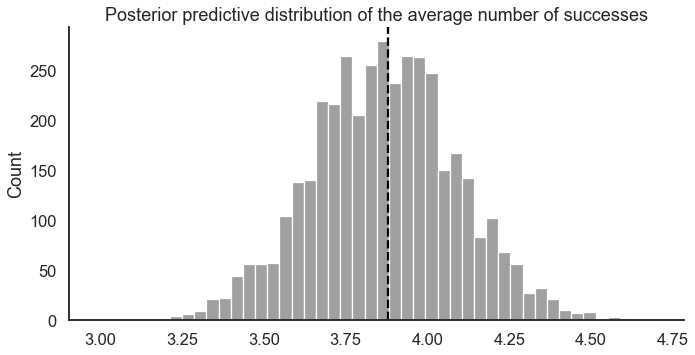

In [34]:
g = sns.displot(np.mean(y_hat, axis=1), aspect=2, color='grey')

g.ax.set_title('Posterior predictive distribution of the average number of successes')
g.ax.axvline(np.mean(data), color='k', linestyle='--');

### Transform to arviz inference data

In [35]:
idata_stan = az.from_pystan(
    posterior=fit,
    posterior_predictive='y_hat',
    observed_data=['y'],
    log_likelihood={'y': "log_likelihood"}
)

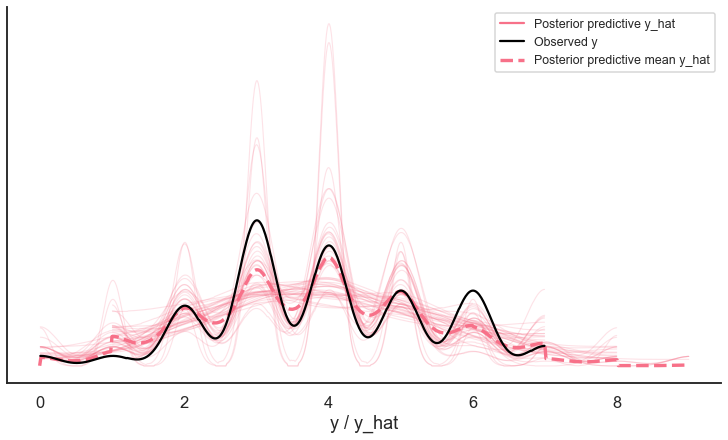

In [36]:
az.plot_ppc(idata_stan, data_pairs={"y":"y_hat"}, num_pp_samples=50)
sns.despine();